# Predict homing error

There is an assumption in the litterature on path integration that error accumulate linearly with distance run. Let's see if this is the case.

In [1]:
import pandas as pd
import numpy as np
import os.path
import pickle
from autopipy.project import Project

In [2]:
projectName="autopi_behavior_2021"
dataPath="/adata/projects/autopi_behavior_2021"
dlcModelPath="/adata/models"
myProject = Project(name=projectName,dataPath=dataPath,dlcModelPath=dlcModelPath)
fn=myProject.dataPath+"/testing_sessions"
print("Reading " + fn)
sessionNamesTesting = pd.read_csv(fn) # this will be a pandas dataframe
myProject.createSessionList(sessionNameList=sessionNamesTesting.sessionName.to_list())
print("We have {} recording sessions".format(len(myProject.sessionList)))

Project name: autopi_behavior_2021
dataPath: /adata/projects/autopi_behavior_2021
dlcModelPath: /adata/models
Reading /adata/projects/autopi_behavior_2021/testing_sessions
We have 67 recording sessions


In [3]:
# load the training DataFrame
fn =  myProject.dataPath+"/results/trialsTrainSet.csv"
df = pd.read_csv(fn)
print("Number of trials from trial DataFrame: {}".format(len(df)))

# load the speed profile (dict of np.arrays)
fn =  myProject.dataPath+"/results/sProfileTrainSet.pkl"
print("loading pickle {}".format(fn))
sProfile = pickle.load(open(fn, "rb" ) )
print("Number of trilas from speed profiles: {}".format(sProfile["searchTotal"].shape[0]))



Number of trials from trial DataFrame: 4520
loading pickle /adata/projects/autopi_behavior_2021/results/sProfileTrainSet.pkl
Number of trilas from speed profiles: 4520


In [4]:
# remove invalid trials
boolIndices = df.valid
print("Number of valid trials: {}".format(sum(boolIndices)))

df = df[boolIndices]
for k in sProfile:
    sProfile[k] = sProfile[k][boolIndices,:]

if sProfile["searchTotal"].shape[0] != len(df):
    print("Problem with the length of sProfile and df")

Number of valid trials: 4453


## Measures of homing accuracy
We can use two measures of homing accuracy.

* homing heading error
* error at periphery

Before attempting to predict anything, let's have a look at these variables.

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
plt.style.use("seaborn")

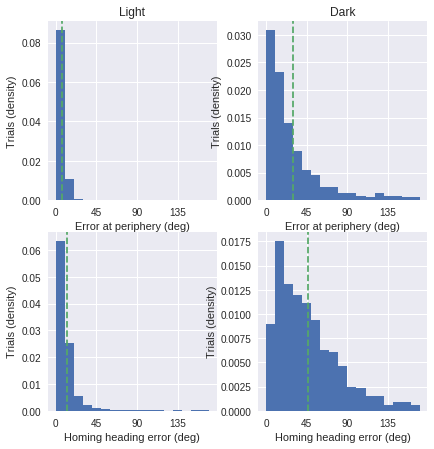

In [6]:
# plot the variables

d = {"variable" : ["angularErrorHomingPeri","homingPeriNoLever_medianMVDeviationToTarget"], 
    "xMin" : [0,0],
     "xMax" : [180,180],
     "xStep" : [10,10],
     "xTicksStep" : [45,45],
     "xLabel": ["Error at periphery (deg)", 
                "Homing heading error (deg)"]}
lc = ["light","dark"]

fig,axes = plt.subplots(len(d["variable"]),len(lc),figsize=(len(lc)*3,len(d["variable"])*3))
plt.subplots_adjust(wspace=0.7,hspace=0.5)
fig.tight_layout()

for i,v in enumerate(d["variable"]):
    for j,l in enumerate(lc):
        if(i==0):
            axes[i,j].set_title(l.capitalize())
        x = df[v][(df.light==l)]
        axes[i,j].hist(x,density=True, bins=np.arange(d["xMin"][i],d["xMax"][i],d["xStep"][i]))
        axes[i,j].axvline(x=np.nanmean(x),linestyle='dashed',color=sns.color_palette()[1])
        axes[i,j].set_xticks(np.arange(d["xMin"][i],d["xMax"][i],d["xTicksStep"][i]))
        axes[i,j].set_xlabel(d["xLabel"][i])
        axes[i,j].set_ylabel("Trials (density)")

These distributions are heavily positively skewed. We will transform them to get something that looks more like a normal distribution.

The function `np.log1p()` seems to do a good job.

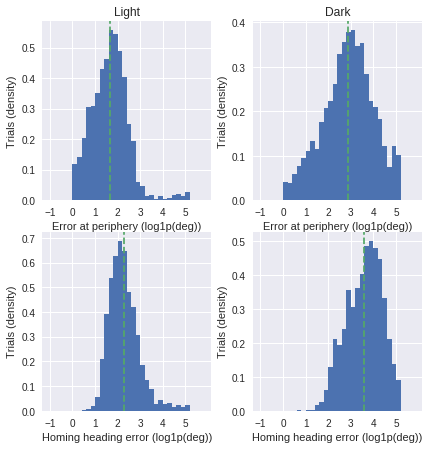

In [7]:
df["logAngularErrorHomingPeri"] = np.log1p(df["angularErrorHomingPeri"])
df["homingPeriNoLever_logMedianMVDeviationToTarget"] = np.log1p(df["homingPeriNoLever_medianMVDeviationToTarget"])

d = {"variable" : ["logAngularErrorHomingPeri","homingPeriNoLever_logMedianMVDeviationToTarget"], 
    "xMin" : [-1,-1],
     "xMax" : [6,6],
     "xStep" : [0.2,0.2],
     "xTicksStep" : [1,1],
     "xLabel": ["Error at periphery (log1p(deg))", 
                "Homing heading error (log1p(deg))"]}
lc = ["light","dark"]




fig,axes = plt.subplots(len(d["variable"]),len(lc),figsize=(len(lc)*3,len(d["variable"])*3))
plt.subplots_adjust(wspace=0.7,hspace=0.5)
fig.tight_layout()

for i,v in enumerate(d["variable"]):
    for j,l in enumerate(lc):
        if(i==0):
            axes[i,j].set_title(l.capitalize())
        x = df[v][(df.light==l)]
        axes[i,j].hist(x,density=True, bins=np.arange(d["xMin"][i],d["xMax"][i],d["xStep"][i]))
        axes[i,j].axvline(x=np.nanmean(x),linestyle='dashed',color=sns.color_palette()[1])
        axes[i,j].set_xticks(np.arange(d["xMin"][i],d["xMax"][i],d["xTicksStep"][i]))
        axes[i,j].set_xlabel(d["xLabel"][i])
        axes[i,j].set_ylabel("Trials (density)")

This is not perfect but looks better.

You might wonder what is the equivalent of degrees on the log1p scale. See the plot below

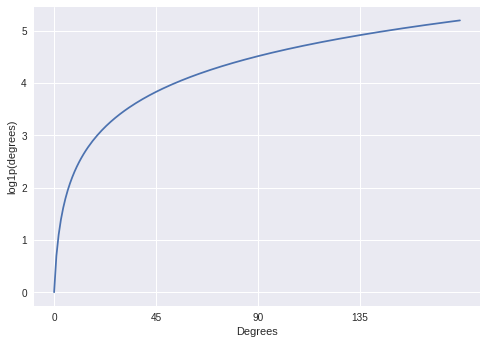

In [8]:
x = np.arange(0,180,1)
y = np.log1p(x)
plt.plot(x,y)
plt.xlabel("Degrees")
plt.ylabel("log1p(degrees)")
plt.xticks(np.arange(0,180,45))
plt.show()

# Predictors

Now that we have homing accuracy measures that are almost normally distributed, we can have a look at the variables we would like to use as predictors.

An obvious candidate is the searching path until the lever was pressed. This is the path called "searchArena"


light


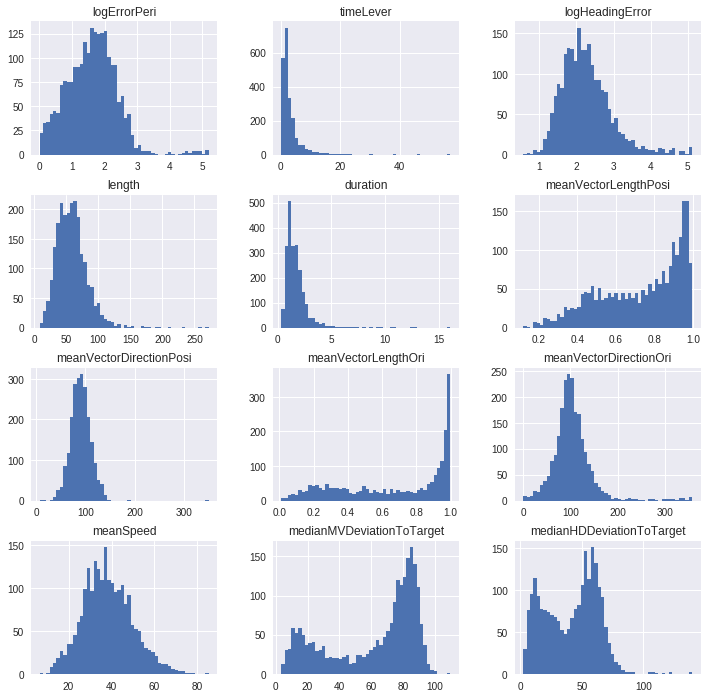

dark


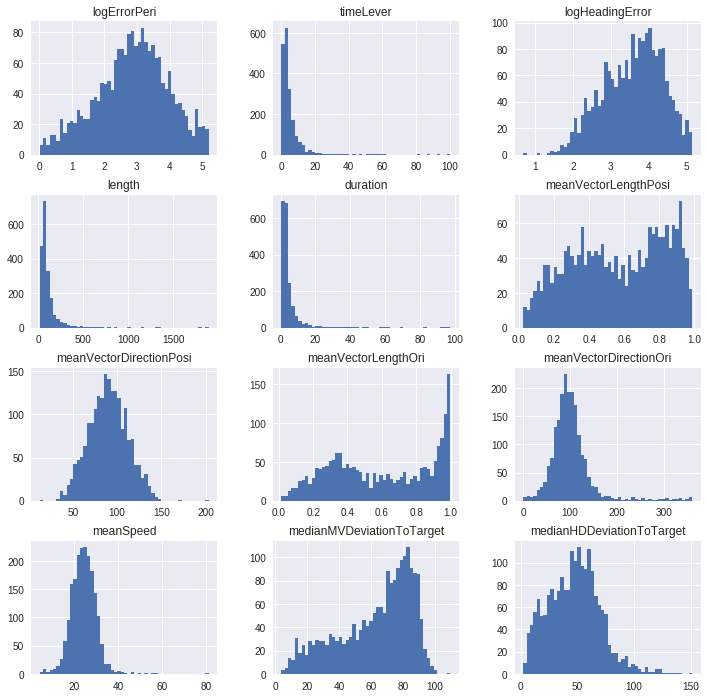

In [9]:
df1 = df.filter(regex=("searchArena_+")) # our predictor
df1 = pd.concat([df[["logAngularErrorHomingPeri",
                     "timeLever","homingPeriNoLever_logMedianMVDeviationToTarget","light"]],df1],axis=1) 
# add our predited values to get rid of some trials


df1 = df1.dropna() # get rid of invalid values
oldName = df1.columns
df1 = df1.rename(columns = {"logAngularErrorHomingPeri": "logErrorPeri",
                            "AngularErrorHomingPeri": "errorPeri",
                            "homingPeriNoLever_logMedianMVDeviationToTarget" : "logHeadingError"})

df1.columns = df1.columns.str.lstrip("searchArena_")

df1 = df1[df1.columns.drop(list(df1.filter(regex='Angular')))]

print("light")
df1[df1.light=="light"].hist(figsize=(12,12),bins=50)
plt.show()
print("dark")
df1[df1.light=="dark"].hist(figsize=(12,12),bins=50)
plt.show()

`length` and `duration` can be `log` improved with a log transformation.


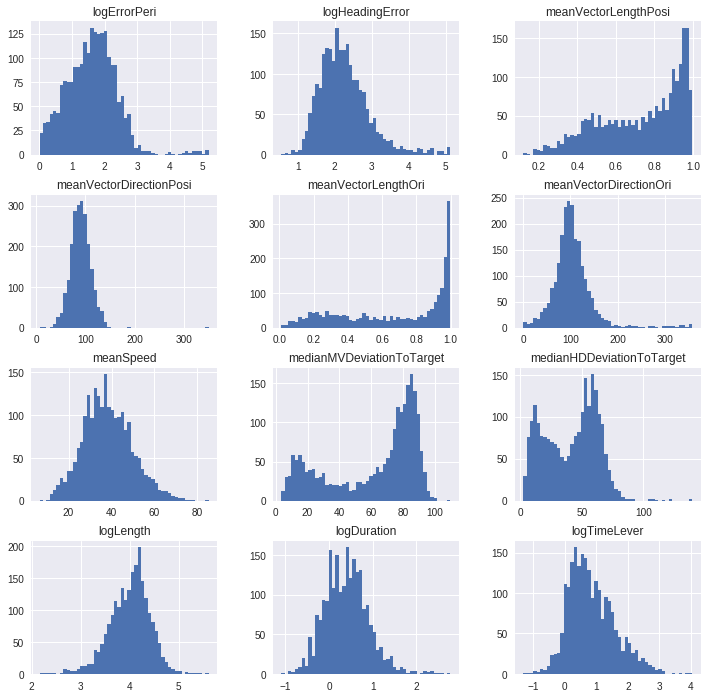

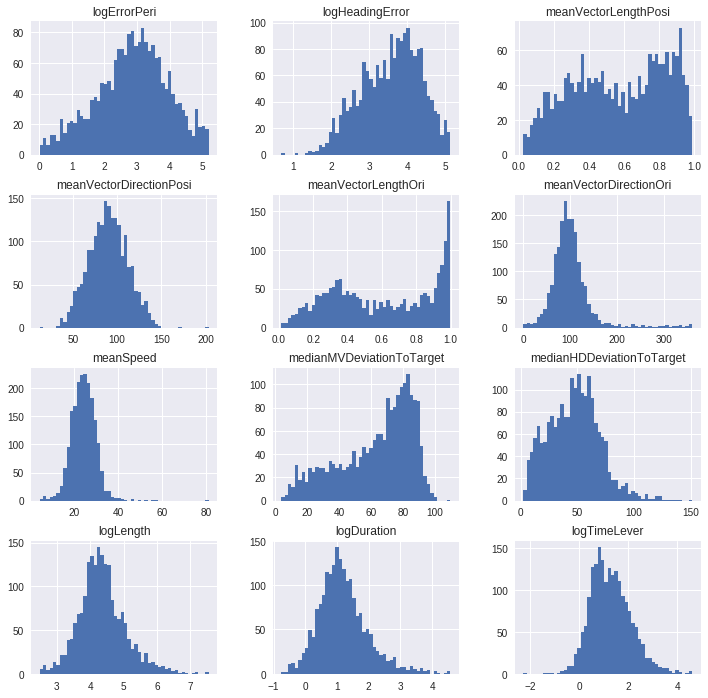

In [10]:
df1["logLength"] = np.log(df1["length"])
df1["logDuration"] = np.log(df1["duration"])
df1["logTimeLever"] = np.log(df1["timeLever"])

#drop the original length
df1 = df1.drop(["length","duration","timeLever"],axis=1)


df1[df1.light=="light"].hist(figsize=(12,12),bins=50)
plt.show()
df1[df1.light=="dark"].hist(figsize=(12,12),bins=50)
plt.show()

## Correlation structure in the data

Let's have a look how the variables are related to each other.


light


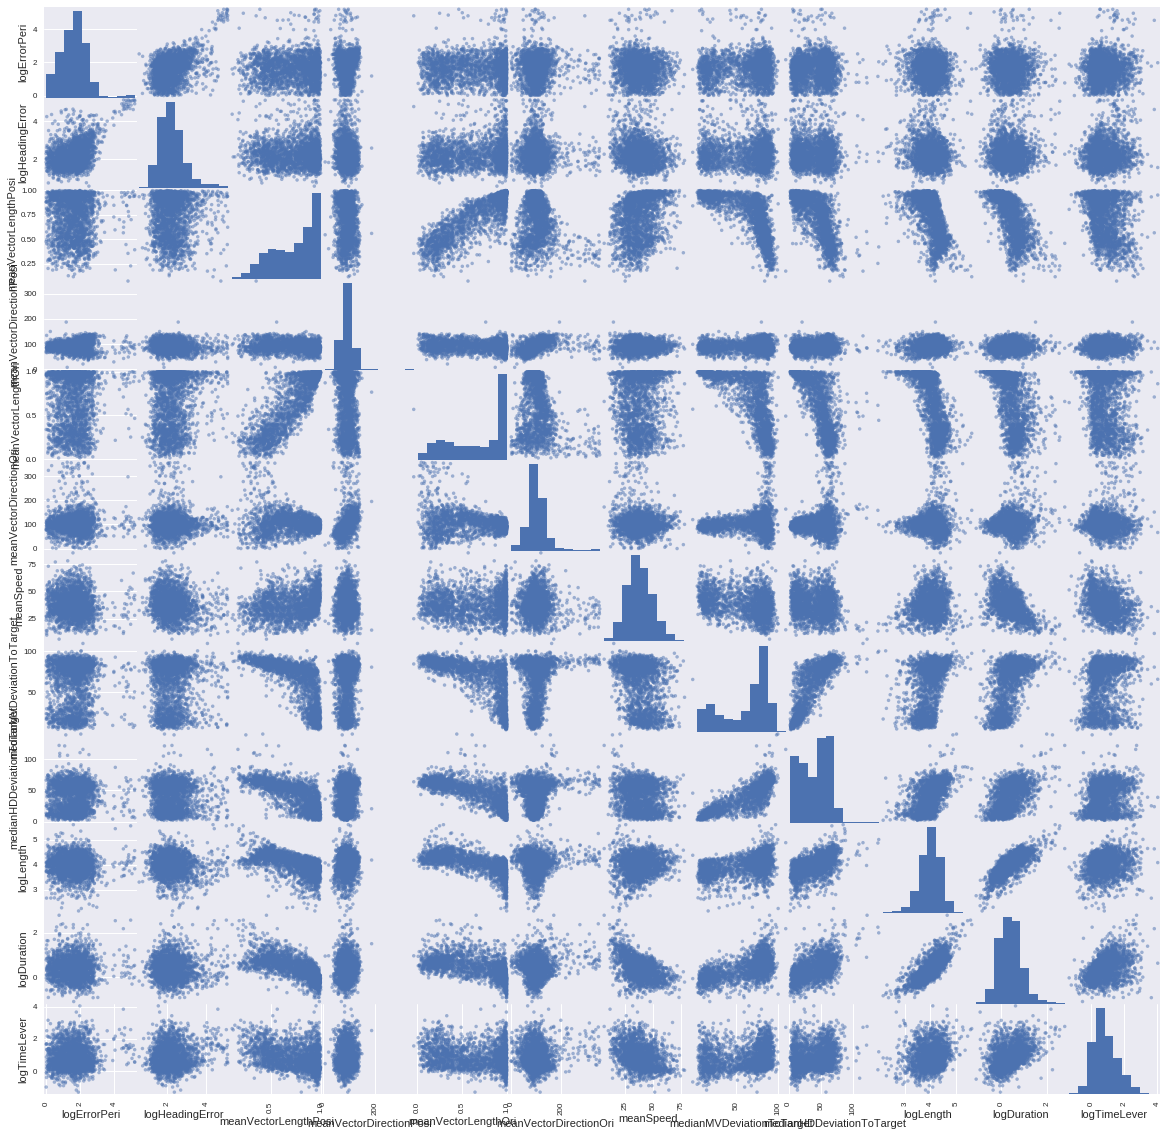

dark


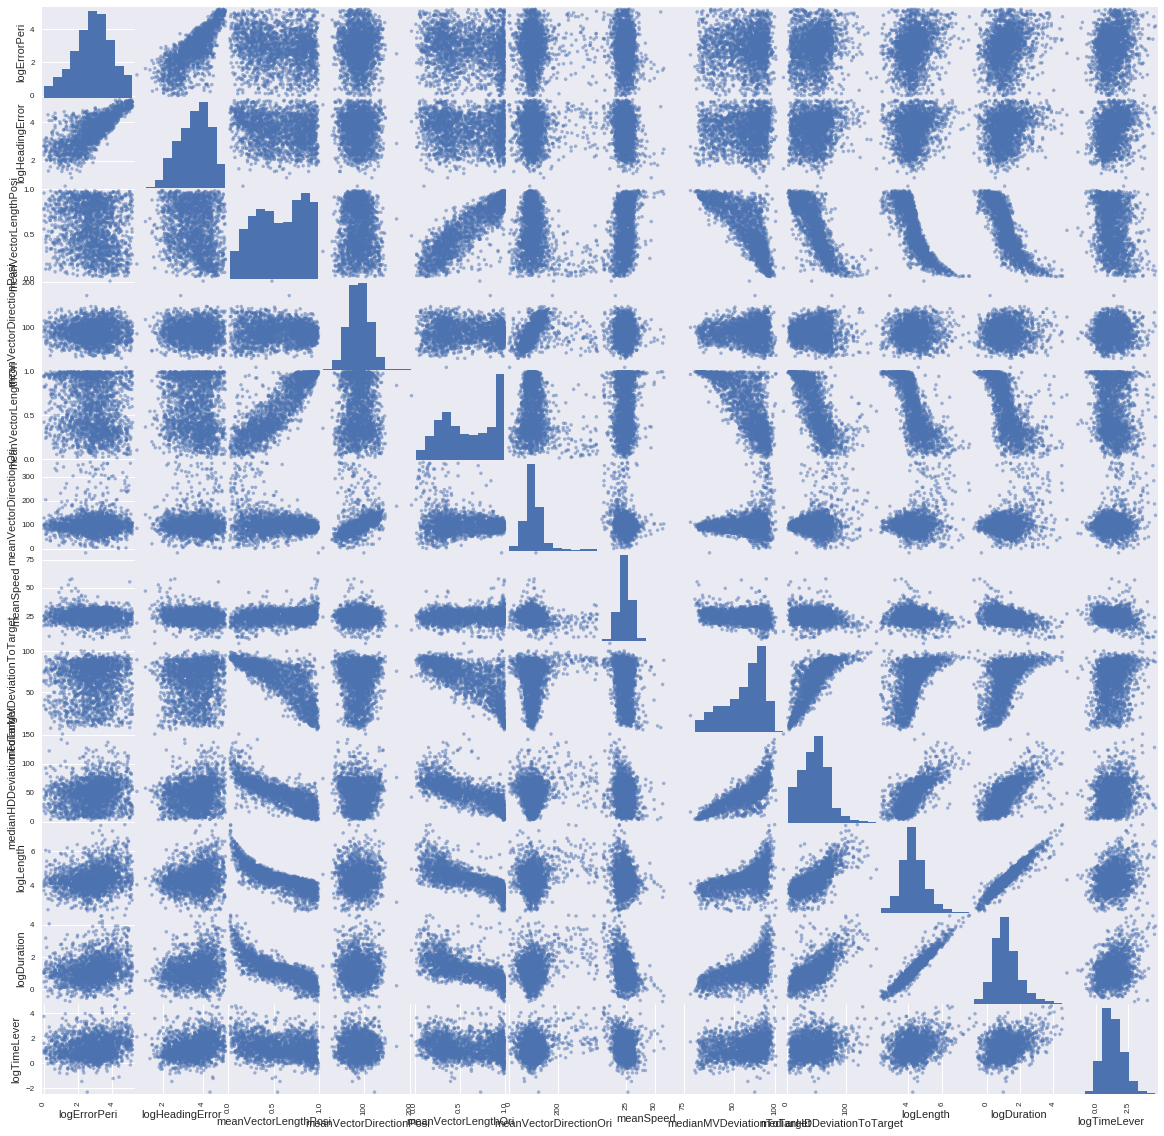

In [11]:
from pandas.plotting import scatter_matrix

for l in lc:
    print(l)
    dfC = df1[df1.light == l]
    scatter_matrix(dfC,figsize=(20,20))
    plt.show()

# Predictions

The data look reasonably good to have a first go at predicting homing error.

Let's first just get a correlation matrix between these variables.


In [12]:
for l in lc:
    print()
    print(l)
    dfC = df1[df1.light == l]
    corrMatrix = dfC.corr()
    print(corrMatrix.iloc[2:,0:2])


light
                           logErrorPeri  logHeadingError
meanVectorLengthPosi           0.009847         0.018178
meanVectorDirectionPosi        0.068019        -0.090311
meanVectorLengthOri            0.013386         0.118484
meanVectorDirectionOri         0.035176        -0.030763
meanSpeed                     -0.060792        -0.145781
medianMVDeviationToTarget      0.029698        -0.015405
medianHDDeviationToTarget      0.046687        -0.038505
logLength                     -0.035260        -0.108535
logDuration                    0.013749         0.013078
logTimeLever                   0.065588         0.124128

dark
                           logErrorPeri  logHeadingError
meanVectorLengthPosi          -0.144111        -0.173031
meanVectorDirectionPosi       -0.005258        -0.028402
meanVectorLengthOri           -0.110436        -0.075186
meanVectorDirectionOri         0.029510         0.023838
meanSpeed                     -0.088243        -0.163500
medianMVDeviationT

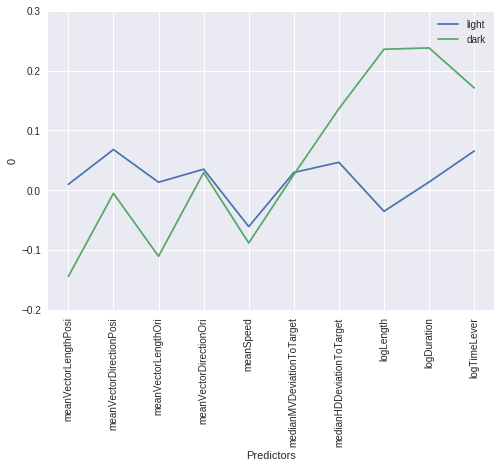

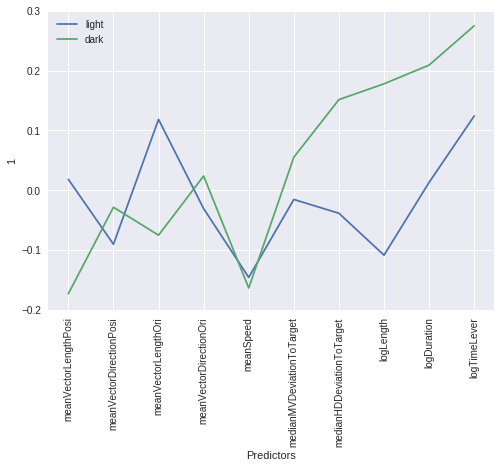

In [13]:
for vi in range(2):
    for l in lc:
        dfC = df1[df1.light == l]
        corrMatrix = dfC.corr()
        plt.plot(corrMatrix.iloc[2:,vi],label=l)
    plt.legend()
    plt.xlabel("Predictors")
    plt.ylabel(vi)
    plt.xticks(rotation=90)
    plt.ylim(-0.2,0.3)
    plt.show()


In [14]:
from scipy.stats import pearsonr
for l in lc:
    print()
    print(l)
    dfC = df1[df1.light == l]
    for var in ["logErrorPeri","logHeadingError"]:
        print(var)
        for pre in ["logTimeLever","logLength", "logDuration", "medianHDDeviationToTarget", "meanSpeed","meanVectorLengthPosi"]:
            print(var,pre,pearsonr(dfC[pre], dfC[var]))


light
logErrorPeri
logErrorPeri logTimeLever (0.06558788205633435, 0.002002961064415759)
logErrorPeri logLength (-0.03526026643701252, 0.09695258612418096)
logErrorPeri logDuration (0.013748768900765648, 0.5176146793675012)
logErrorPeri medianHDDeviationToTarget (0.04668673055574861, 0.027934502418460915)
logErrorPeri meanSpeed (-0.060791938623649594, 0.004190887658428856)
logErrorPeri meanVectorLengthPosi (0.009847443008299895, 0.6430655782465761)
logHeadingError
logHeadingError logTimeLever (0.12412763660266396, 4.519893096037213e-09)
logHeadingError logLength (-0.1085354997957497, 3.0126489719906303e-07)
logHeadingError logDuration (0.013077692457821784, 0.5382624798465676)
logHeadingError medianHDDeviationToTarget (-0.03850483357859132, 0.0698856775476191)
logHeadingError meanSpeed (-0.1457808578154522, 5.3074681711266334e-12)
logHeadingError meanVectorLengthPosi (0.01817835147752251, 0.3922654496623096)

dark
logErrorPeri
logErrorPeri logTimeLever (0.17114288638525388, 2.27273372

## Figure for manuscript

We want to show examples to explain the possible link between homing error and the search path variables.


In [15]:
ses1 = myProject.sessionList[20]
ses1.extractTrialFeatures()
ses2 = myProject.sessionList[0]
ses2.extractTrialFeatures()
ses3 = myProject.sessionList[10]
ses3.extractTrialFeatures()

mn4673-06102019-1534 trial segmentation
Remove door closing event at the beginning of the session, index 21
problem with the door alternation
Problem with index 908
Removing the second of two door closings (index :908)
Problem with index 1614
Removing the second of two door closings (index :1614)
Number of trials : 89
mn4673-06102019-1534, video len: 108793, video-log len:108793, first frame: 0, max log gap: 7.0, mean time diff: 0.0335, max time diff: 0.126, num problem diff: 0, frame rate: 29.8
Lenght of mouseLeverPosi: 108793
Lenght of videoLog: 108793
mn4673-06102019-1534_4, self.startTime was adjusted by -0.2 s
mn4673-06102019-1534_5, self.startTime was adjusted by -0.3 s
mn4673-06102019-1534_7, self.startTime was adjusted by -0.2 s
mn4673-06102019-1534_8, self.startTime was adjusted by -0.3 s
mn4673-06102019-1534_9, self.startTime was adjusted by -0.3 s
mn4673-06102019-1534_10, self.startTime was adjusted by -0.3 s
mn4673-06102019-1534_11, self.startTime was adjusted by -0.2 s
mn4

/home/maryam/repo/autopipy/autopipy/trial.py:1225: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(np.sum(uv*urv,axis=1))


mn4672-02102019-1809_15, self.startTime was adjusted by -0.6 s
mn4672-02102019-1809_18, self.startTime was adjusted by -0.1 s
mn4672-02102019-1809_19, self.startTime was adjusted by -0.1 s
mn4672-02102019-1809_24, self.startTime was adjusted by -0.2 s
mn4672-02102019-1809_25, self.startTime was adjusted by -0.2 s
mn4672-02102019-1809_26, self.startTime was adjusted by -0.1 s
mn4672-02102019-1809_27, self.startTime was adjusted by -0.3 s
mn4672-02102019-1809_29, self.startTime was adjusted by -0.2 s
mn4672-02102019-1809_32, self.startTime was adjusted by -0.2 s
mn4672-02102019-1809_33, self.startTime was adjusted by -0.2 s
There is a journey starting after the first lever press
   start    end
0  53333  53513
1  53514  54263
2  54264  54736
3  54737  55367
             time  videoIndex
867  1.570034e+09       54312
870  1.570034e+09       55004
lastEnd: 55367
mn4672-02102019-1809_34, self.startTime was adjusted by -0.1 s
mn4672-02102019-1809_37, mouse not in the lever zone when the leve

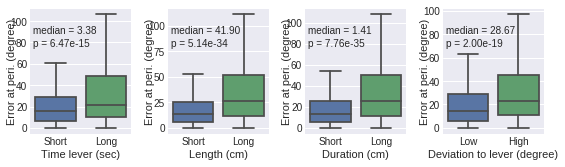

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
plt.style.use("seaborn")


al=0.6
my_pal = {"Light trials": sns.color_palette()[4], "Dark trials": sns.color_palette()[0]}
col=4
row=1
sizePerPlot=2.3
fig = plt.figure(figsize=(col*sizePerPlot,row*sizePerPlot))
gs = gridspec.GridSpec(row,col,wspace=0.36, hspace=0.27) #
fig.tight_layout()

dfDark= df[df.light=="dark"]

d = {"var": ["angularErrorHomingPeri"],
     "varNames" : ["Error at peri. (degree)"],
     "predictors" : ["timeLever","searchArenaNoLever_length",
                     "searchArenaNoLever_duration", "searchArenaNoLever_medianMVDeviationToTarget"],
     "predictorNames" : ["Time lever (sec)", "Length (cm)", "Duration (cm)", "Deviation to lever (degree)"],
     "yCoord" : [-0.13,-0.13,-0.13,-0.13],
    "pValueX": [0.03,0.03,0.03,0.03] ,
    "xLabels": [["Short","Long"],["Short","Long"],["Short","Long"],["Low","High"]]}

for i,pred in enumerate(d["predictors"]):
    ax = plt.subplot(gs[i])
    myMedian = dfDark[pred].median()
    dfDark["grouping"] = np.where(dfDark[pred]<myMedian,"short","long")
    ax = sns.boxplot(y=d["var"][0], x="grouping", 
                     data=dfDark,
               showfliers=False,order=["short","long"])
    valS = dfDark[d["var"]][dfDark["grouping"]=="short"]
    valL = dfDark[d["var"]][dfDark["grouping"]=="long"]
    stat,p_value = stats.mannwhitneyu(x=valS, y =valL )
    
    ax.tick_params(axis='both', which='major', pad=3)
    ax.set_xlabel(d["predictorNames"][i])
    ax.set_ylabel(d["varNames"][0])
    ax.xaxis.set_label_coords(0.5, -0.13)
    ax.yaxis.set_label_coords(d["yCoord"][i],0.5)
    ax.text(d["pValueX"][i],0.8, "median = {:.2f}".format(myMedian), transform = ax.transAxes)
    ax.text(d["pValueX"][i],0.7, "p = {:.2e}".format(p_value), transform = ax.transAxes)
    plt.xticks(range(2),labels=d["xLabels"][i])
    
plt.show()



In [17]:
df1

,logErrorPeri,logHeadingError,light,meanVectorLengthPosi,meanVectorDirectionPosi,meanVectorLengthOri,meanVectorDirectionOri,meanSpeed,medianMVDeviationToTarget,medianHDDeviationToTarget,logLength,logDuration,logTimeLever
0,0.599057,3.201194,light,0.676209,82.260613,0.583655,76.045204,23.351943,79.435447,42.946918,4.110921,0.960241,1.628504
1,1.521168,2.980814,light,0.224903,99.352539,0.192451,125.264190,27.471443,87.026950,70.277028,5.154399,1.841252,0.987535
2,4.519566,4.789363,light,0.876394,84.564304,0.911084,99.133933,26.549255,68.164022,28.294048,3.816388,0.537386,1.439615
3,1.482725,1.836302,light,0.927085,81.125766,0.986616,92.330386,34.554693,18.942569,12.012674,3.701132,0.158589,0.574436
4,1.134881,2.026913,light,0.961283,77.948244,0.988808,88.614403,33.387615,13.093064,16.139082,3.547400,0.039215,-0.683753
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4515,1.642705,2.400674,light,0.416673,105.305264,0.294519,77.748824,36.982352,81.734735,68.345151,4.485680,0.875240,1.481207
4516,3.280730,3.774228,dark,0.209171,96.065754,0.505305,122.532215,24.965665,87.975629,74.805042,4.980874,1.763372,1.041328
4517,1.838091,2.538222,light,0.930509,80.801521,0.924364,96.463810,48.869071,68.399815,42.806416,3.953348,0.064203,-0.918200
4518,2.349087,2.828398,dark,0.295505,105.231307,0.409880,105.451567,26.637072,91.541877,70.053414,4.864356,1.582052,-0.761156


Saving to /adata/projects/autopi_behavior_2021/results/predicting_error_01.pdf



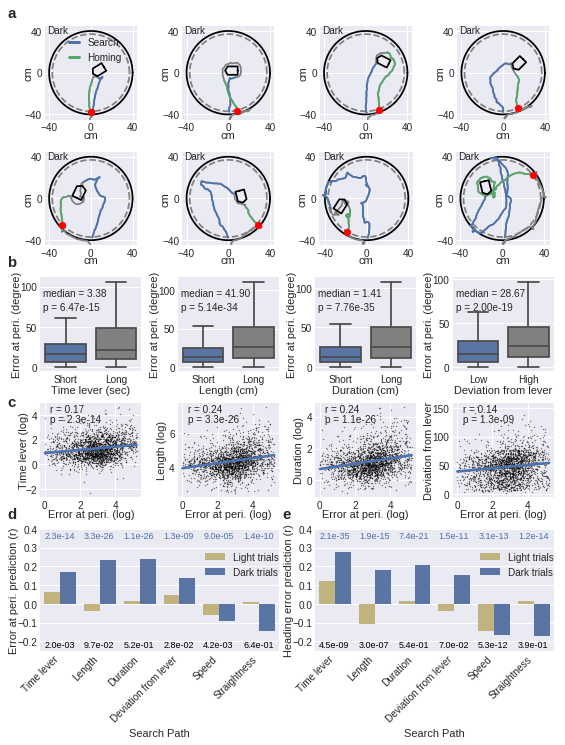

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
plt.style.use("seaborn")
al=0.6
my_pal = {"Light trials": sns.color_palette()[4], "Dark trials": sns.color_palette()[0]}

col=4
row=5
sizePerPlot=2.3
fig = plt.figure(figsize=(col*sizePerPlot,row*sizePerPlot))
gs = gridspec.GridSpec(row,col,wspace=0.36, hspace=0.32,height_ratios = [1,1,1,1,1.3]) #
fig.tight_layout()

# to plot the arena circle
arena=np.arange(start=0,stop=2*np.pi,step=0.02)
arenaRadiusProportionToPeri=0.925
arenaRadius = 40


######################################
## Example of 4 trials             ###
## Long - Complexe -> larger error ###
######################################

mySessions = [ses1,ses2,ses3] 
d = {"sessionIndex" : [0,1,0,1,
                       2,0,2,1],
    "trialIndex" : [22,28,26,60,
                   15,36,13,48]}

for i in range(8) :
        ax = plt.subplot(gs[i//4,i%4])
        ax.set_aspect('equal', adjustable='box')
        ax.plot(np.cos(arena)*arenaRadius,np.sin(arena)*arenaRadius,color="black",zorder=1)
        ax.plot(np.cos(arena)*arenaRadius*arenaRadiusProportionToPeri,np.sin(arena)*arenaRadius*arenaRadiusProportionToPeri,
                       color="gray",linestyle='dashed',zorder=1)
        ax.set_xlabel("cm")
        ax.set_ylabel("cm")
        ax.set_ylim(-45,45)
        ax.xaxis.set_label_coords(0.5, -0.11)
        ax.yaxis.set_label_coords(-0.125, 0.5)
        ax.set_xticks(np.arange(-40,80,40))
        ax.set_yticks(np.arange(-40,80,40))
        ax.tick_params(axis='both', which='major', pad=3)
        #trials = [t for t in ses.trialList if t.light==lc and t.valid]
        t = mySessions[d["sessionIndex"][i]].trialList[d["trialIndex"][i]]
        ## plot the path 
        
        if t.pathD["all"].pPose is not None:
            ax.plot(t.pathD["all"].pPose[:,0],t.pathD["all"].pPose[:,1],color="grey",zorder=1)

        if t.pathD["searchArenaNoLever"].pPose is not None:
            ax.plot(t.pathD["searchArenaNoLever"].pPose[:,0],t.pathD["searchArenaNoLever"].pPose[:,1],label="Search",zorder=2)

        if t.pathD["homingPeriNoLever"].pPose is not None:
            ax.plot(t.pathD["homingPeriNoLever"].pPose[:,0],t.pathD["homingPeriNoLever"].pPose[:,1], label="Homing",zorder=2)
        # plot lever
        lev = np.append(t.leverCm.points,t.leverCm.points[0,:]).reshape((-1,2))
        ax.plot(lev[:,0],lev[:,1],color="black")
        # at peri
        ax.scatter(t.peripheryAfterFirstLeverPressCoordCm[0],
                   t.peripheryAfterFirstLeverPressCoordCm[1],
                   color="red",zorder=3)
        
        ax.text(-42,38, t.light.capitalize())
        if i == 0:
            leg = ax.legend(loc=(0.22,0.57),handlelength=1)
            for line in leg.get_lines():
                line.set_linewidth(3.0)
        #ax.legend()

################
### box plot  ##
## not log    ##
################
  
        
dfDark= df[df.light=="dark"]

d = {"var": ["angularErrorHomingPeri"],
     "varNames" : ["Error at peri. (degree)"],
     "predictors" : ["timeLever","searchArenaNoLever_length",
                     "searchArenaNoLever_duration", "searchArenaNoLever_medianMVDeviationToTarget"],
     "predictorNames" : ["Time lever (sec)", "Length (cm)", "Duration (cm)", "Deviation from lever"],
     "yCoord" : [-0.18,-0.18,-0.18,-0.18],
    "pValueX": [0.03,0.03,0.03,0.03] ,
    "xLabels": [["Short","Long"],["Short","Long"],["Short","Long"],["Low","High"]]}
my_pal2 = {"short": sns.color_palette()[0], "long": "grey"}

for i,pred in enumerate(d["predictors"]):
    ax = plt.subplot(gs[2,i])
    myMedian = dfDark[pred].median()
    dfDark["grouping"] = np.where(dfDark[pred]<myMedian,"short","long")
    ax = sns.boxplot(y=d["var"][0], x="grouping", 
                     data=dfDark, palette=my_pal2,
                     showfliers=False,order=["short","long"])
    valS = dfDark[d["var"]][dfDark["grouping"]=="short"]
    valL = dfDark[d["var"]][dfDark["grouping"]=="long"]
    stat,p_value = stats.mannwhitneyu(x=valS, y =valL )
    
    ax.tick_params(axis='both', which='major', pad=3)
    ax.set_xlabel(d["predictorNames"][i])
    ax.set_ylabel(d["varNames"][0])
    ax.xaxis.set_label_coords(0.5, -0.15)
    ax.yaxis.set_label_coords(d["yCoord"][i],0.5)
    ax.text(d["pValueX"][i],0.8, "median = {:.2f}".format(myMedian), transform = ax.transAxes)
    ax.text(d["pValueX"][i],0.65, "p = {:.2e}".format(p_value), transform = ax.transAxes)
    plt.xticks(range(2),labels=d["xLabels"][i])
    
        
        
        
        
###################
## scatter plots ##
## log           ##
###################
d = {"var": ["logErrorPeri"],
     "varNames" : ["Error at peri. (log)"],
     "predictors" : ["logTimeLever","logLength", "logDuration", "medianHDDeviationToTarget"],
     "predictorNames" : ["Time lever (log)", "Length (log)", "Duration (log)", "Deviation from lever"],
    "yCoord" : [-0.11,-0.11,-0.11,-0.18]}

for i, pred in enumerate(d["predictors"]):
    ax = plt.subplot(gs[3,i])
    ax = sns.regplot(y=pred, x=d["var"][0], data=df1[df1.light=="dark"],
                     scatter_kws={"color": "black",'s':2, 'alpha':0.5}, line_kws={"color": sns.color_palette()[0]})
    ax.tick_params(axis='both', which='major', pad=3)
    ax.set_ylabel(d["predictorNames"][i])
    ax.set_xlabel(d["varNames"][0])
    ax.xaxis.set_label_coords(0.5, -0.13)
    ax.yaxis.set_label_coords(d["yCoord"][i],0.5)
    #
    r,p = pearsonr(df1[d["var"][0]][df1.light=="dark"],
                   df1[pred][df1.light=="dark"])
    ax.text(0.1,0.9, "r = {:.2}".format(r), transform = ax.transAxes)
    ax.text(0.1,0.8, "p = {:.2}".format(p), transform = ax.transAxes)
    
    
    
###########################
## Homing error at peri ###
###########################
d = {"var": ["logErrorPeri","logHeadingError"],
     "varNames" : ["Error at peri. prediction (r)", "Heading error prediction (r)"]}
for i in range(2):
    predictors = ["logTimeLever","logLength", "logDuration", "medianHDDeviationToTarget", "meanSpeed","meanVectorLengthPosi"]
    predicted = d["var"][i]
    lc = ["light","dark"]
    plotDf = pd.DataFrame({"light":[],"predictor":[],"r":[]})
    for l in lc:
        dfC = df1[df1.light == l]
        corrMatrix = dfC.corr()
        for pr in predictors:
            r,p = pearsonr(dfC[pr],dfC[predicted])
            oneRowDf = pd.DataFrame({"light":["{} trials".format(l.capitalize())],"predictor":[pr],"r":[r],"p":[p]})
            plotDf = plotDf.append(oneRowDf)
    #print(plotDf)
    ax = plt.subplot(gs[4,i*2:i*2+2])
    sns.barplot(x='predictor',y='r',data=plotDf, hue = "light", palette=my_pal,ax=ax)
    ax.set_ylabel(d["varNames"][i])
    ax.set_xlabel("Search Path")
    ax.set_ylim(-0.25,0.30)
    labels=["Time lever","Length","Duration","Deviation from lever","Speed", "Straightness"]
    ax.set_xticklabels(labels=labels, rotation=45, ha='right')
    plt.yticks(np.arange(-0.2,0.4,0.1))
    ax.legend(loc=(0.675,0.57))
    #x.xaxis.set_label_coords(0.5, -0.20)
    ax.yaxis.set_label_coords(-0.09,0.5)
    ax.tick_params(axis='both', which='major', pad=3)
    ## add the p values
    for j,pre in enumerate(predictors):
        p=plotDf["p"][(plotDf.light=="Dark trials") & (plotDf.predictor == pre)].item()
        ax.text(j-0.4,0.35,"{:.1e}".format(p),style="normal",fontsize=9,color=my_pal["Dark trials"])
        p=plotDf["p"][(plotDf.light=="Light trials") & (plotDf.predictor == pre)].item()
        ax.text(j-0.4,-0.23,"{:.1e}".format(p),style="normal",fontsize=9,color="black")# my_pal["Light trials"])
 
#######################################
### letters 
#######################################
plt.text(0.075,0.89, 'a', style='normal',fontsize=15, weight="bold", transform=plt.gcf().transFigure)
plt.text(0.075,0.59, 'b', style='normal',fontsize=15, weight="bold", transform=plt.gcf().transFigure)
plt.text(0.075,0.42, 'c', style='normal',fontsize=15, weight="bold", transform=plt.gcf().transFigure)
plt.text(0.075,0.285, 'd', style='normal',fontsize=15, weight="bold", transform=plt.gcf().transFigure)
plt.text(0.49,0.285, 'e', style='normal',fontsize=15, weight="bold", transform=plt.gcf().transFigure)
    
###################
# Save the figure #
###################
fileName = myProject.dataPath+"/results/predicting_error_01.pdf"
print("Saving to " + fileName)
print("")
plt.savefig(fileName,bbox_inches = "tight", dpi=400)

,light,predictor,r,p
0,Light trials,logTimeLever,0.134234,3.036390e-08
0,Light trials,logLength,-0.120927,6.167307e-07
0,Light trials,logDuration,0.002732,9.106365e-01
0,Light trials,medianHDDeviationToTarget,-0.029069,2.323267e-01
0,Light trials,meanSpeed,-0.135547,2.219229e-08
0,Light trials,meanVectorLengthPosi,0.028589,2.401410e-01
0,Dark trials,logTimeLever,0.278400,4.946589e-28
0,Dark trials,logLength,0.188975,1.711469e-13
0,Dark trials,logDuration,0.224358,1.595936e-18
0,Dark trials,medianHDDeviationToTarget,0.163118,2.204349e-10


# Multi-variable error prediction

It would be great to show that we can predict the homing error with some models using the 6 variables showed above.

We could compare the model to shuffled prediction. A scatter plot of error vs predicted error.


In [34]:
print(df1.columns)
predictors = ["logTimeLever","logLength", "logDuration", "medianHDDeviationToTarget", "meanSpeed","meanVectorLengthPosi"]
predicted = ["logErrorPeri","logHeadingError"]

Index(['logErrorPeri', 'logHeadingError', 'light', 'meanVectorLengthPosi',
       'meanVectorDirectionPosi', 'meanVectorLengthOri',
       'meanVectorDirectionOri', 'meanSpeed', 'medianMVDeviationToTarget',
       'medianHDDeviationToTarget', 'logLength', 'logDuration',
       'logTimeLever'],
      dtype='object')


In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

X = df1[df1.light=="dark"]
X = X[predictors]
y = df1[df1.light=="dark"]
y = y[predicted[0]]
print(X.shape,y.shape)

lin_reg = LinearRegression()
tree_reg = DecisionTreeRegressor()
forest_reg = RandomForestRegressor()
svm_reg = SVR()

scores = cross_val_score(lin_reg, X,y,scoring = "neg_mean_squared_error",cv=10)
print("lin reg: {}".format(np.sqrt(-scores)))
scores = cross_val_score(tree_reg, X,y,scoring = "neg_mean_squared_error",cv=10)
print("tree reg: {}".format(np.sqrt(-scores)))
scores = cross_val_score(forest_reg, X,y,scoring = "neg_mean_squared_error",cv=10)
print("forest reg: {}".format(np.sqrt(-scores)))
scores = cross_val_score(svm_reg, X,y,scoring = "neg_mean_squared_error",cv=10)
print("svm reg: {}".format(np.sqrt(-scores)))



(1496, 6) (1496,)
lin reg: [1.01330546 1.01454907 1.105716   1.03123158 1.05734003 1.03164213
 1.02049833 1.09821265 1.0145915  1.17638883]
tree reg: [1.4443167  1.47755955 1.64007572 1.42024166 1.44352038 1.493867
 1.49632674 1.5410498  1.4436655  1.58417713]
forest reg: [1.07720696 1.05731046 1.14051235 1.08511831 1.05457186 1.0331332
 1.06273492 1.12925226 1.08034252 1.15645128]
svm reg: [1.05969278 1.05372009 1.12364835 1.06957211 1.04496548 1.05197003
 1.04074484 1.13226746 1.03468809 1.17282664]


(0.3050258398613333, 1.3984054263231885e-33)


(0, 5)

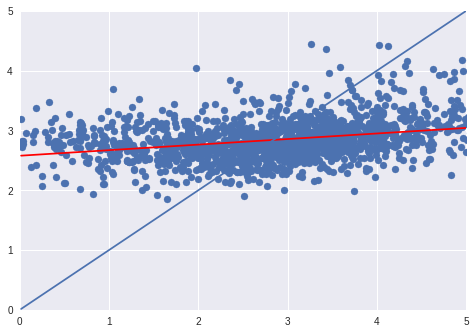

In [60]:
from scipy import stats

lin_reg.fit(X,y)
pred = lin_reg.predict(X)
print(pearsonr(y,pred))

gradient, intercept, r_value, p_value, std_err = stats.linregress(y,pred)
mn=np.min(y)
mx=np.max(y)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
x2=np.linspace(mn,mx,500)
y2=x2

plt.scatter(y,pred)
plt.plot(x1,y1,color="red")
plt.plot(x2,y2)
plt.xlim(0,5)
plt.ylim(0,5)